In [33]:
import gensim
import pyLDAvis.gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from pprint import pprint

import numpy as np
import pandas as pd
import seaborn as sb
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
from IPython.core.display import HTML
np.random.seed(2020)

In [34]:
df = pd.read_csv("../input/news_dataset.csv")
df.head()

,constituent_name,news_title,news_date
0,LINDE PLC,Hydrogen Generator Market 2019 Global Industry...,2019-08-22 00:00:00 UTC
1,RWE AG,Germany stocks lower at close of trade; DAX do...,2019-08-14 00:00:00 UTC
2,VONOVIA SE,Germany stocks higher at close of trade; DAX u...,2019-08-19 00:00:00 UTC
3,FRESENIUS SE & CO. KGAA,German shares gain 1.32 pct Monday,2019-08-19 00:00:00 UTC
4,FRESENIUS SE & CO. KGAA,German shares edge up Tuesday,2019-08-13 00:00:00 UTC


In [35]:
# Visualization 
# Top words used across all one million news titles
datafile = df['news_title']

# Defining the helper function
def top_words(top_n_words, count_vectorizer, text_data): # Returning a tuple of the top n words in a sample & their accompanying counts

    vectorized_titles = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_titles, axis = 0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((top_n_words, vectorized_titles.shape[1]))
    for i in range(top_n_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:top_n_words].tolist()[0])

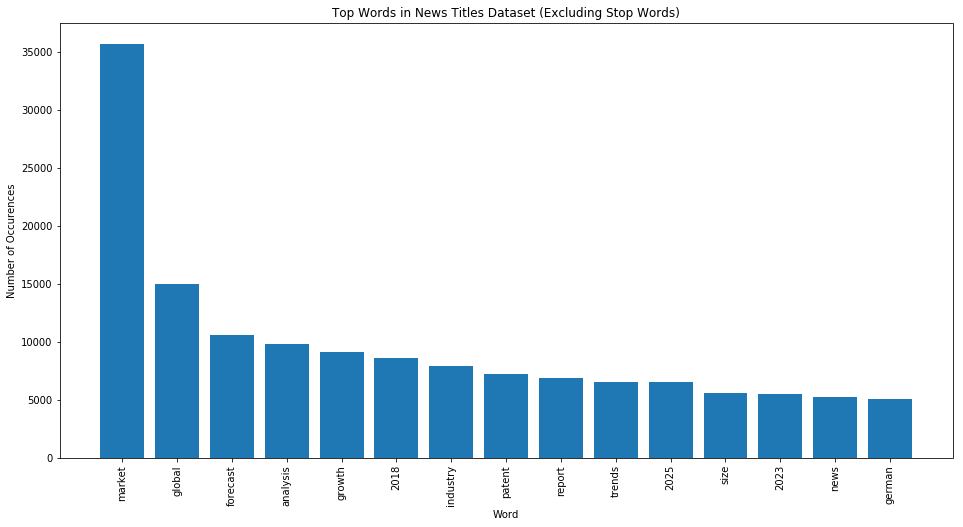

In [36]:
# Omitting stop words
count_vectorizer = CountVectorizer(stop_words = 'english')
words, word_values = top_words(top_n_words = 15, count_vectorizer = count_vectorizer, text_data = datafile)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation = 'vertical');
ax.set_title('Top Words in News Titles Dataset (Excluding Stop Words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of Occurences');
plt.show()

In [40]:
text_data = df[['news_title']]
text_data['index'] = text_data.index
documents = text_data

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [41]:
len(documents)

100000

In [42]:
documents[:10]

,news_title,index
0,Hydrogen Generator Market 2019 Global Industry...,0
1,Germany stocks lower at close of trade; DAX do...,1
2,Germany stocks higher at close of trade; DAX u...,2
3,German shares gain 1.32 pct Monday,3
4,German shares edge up Tuesday,4
5,"JSA, Murali & Co lead on AWI acquisition of ga...",5
6,RWE buys 49% stake in Slovakian VSEH as part o...,6
7,"WIPO PUBLISHES PATENT OF LINDE FOR ""METHOD AND...",7
8,WIPO PUBLISHES PATENT OF DAVID MILNER AND LIND...,8
9,"US Patent Issued to LINDE on Aug. 13 for ""Proc...",9


In [43]:
# Data Preprocessing
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [44]:
stemmer = SnowballStemmer('english')

In [45]:
def stem_lemmatize(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos = 'v'))

In [46]:
def preprocessing(text):
    outcome = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS:
            outcome.append(stem_lemmatize(token))
    return outcome

In [47]:
sample_news = documents[documents['index'] == 9860].values[0][0]

print('The Original Document: ')
words = []
for news in sample_news.split(' '):
    words.append(news)
print(words)
print('\n\n Lemmatized & Tokenized Document: ')
print(preprocessing(sample_news))

The Original Document: 
['BRIEF-BASF', 'says', 'closes', 'acquisition', 'of', 'vegetable', 'seeds', 'business', 'from', 'Bayer']


 Lemmatized & Tokenized Document: 
['brief', 'basf', 'say', 'close', 'acquisit', 'veget', 'seed', 'busi', 'bayer']


In [48]:
records_processed = documents['news_title'].map(preprocessing)

In [49]:
records_processed[:20]

0     [hydrogen, generat, market, global, industri, ...
1            [germani, stock, lower, close, trade, dax]
2           [germani, stock, higher, close, trade, dax]
3                    [german, share, gain, pct, monday]
4                         [german, share, edg, tuesday]
5     [jsa, murali, lead, awi, acquisit, gas, biz, p...
6              [rwe, buy, stake, slovakian, vseh, deal]
7     [wipo, publish, patent, lind, method, devic, t...
8     [wipo, publish, patent, david, milner, lind, m...
9     [patent, issu, lind, aug, process, produc, pur...
10    [dgap, pvr, prosiebensat, media, se, gemäß, ab...
11    [australia, patent, method, cold, gas, spray, ...
12     [rwe, ag, rwe, acquir, stake, slovak, vse, hold]
13    [global, polybutylen, terephthal, pbt, market,...
14    [billion, polyurethan, dispers, market, global...
15    [global, polyurethan, dispers, market, size, s...
16    [plastic, compound, market, near, billion, com...
17    [textil, chemic, market, outlook, forecast

In [50]:
#  Bag of Words on the news_title
dictionary = gensim.corpora.Dictionary(records_processed)

In [51]:
corpus = [dictionary.doc2bow(doc) for doc in records_processed]
corpus[9860]

[(16, 1),
 (29, 1),
 (164, 1),
 (179, 1),
 (218, 1),
 (400, 1),
 (787, 1),
 (6497, 1),
 (6781, 1)]

In [52]:
doc_9860 = corpus[9860]

for i in range(len(doc_9860)):
    print("Word {} (\"{}\") shows up {} time.".format(doc_9860[i][0], dictionary[doc_9860[i][0]], doc_9860[i][1]))

Word 16 ("close") shows up 1 time.
Word 29 ("acquisit") shows up 1 time.
Word 164 ("say") shows up 1 time.
Word 179 ("bayer") shows up 1 time.
Word 218 ("brief") shows up 1 time.
Word 400 ("busi") shows up 1 time.
Word 787 ("basf") shows up 1 time.
Word 6497 ("seed") shows up 1 time.
Word 6781 ("veget") shows up 1 time.


In [53]:
# LDA using Bag of Words
# passes = 15 (To make more sense in topics)
model_bow = gensim.models.LdaMulticore(corpus, num_topics = 10, id2word = dictionary, passes = 15, workers = 2)
model_bow.save('lda.model')

for idx, topic in model_bow.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.044*"trade" + 0.038*"stock" + 0.026*"european" + 0.021*"lufthansa" + 0.018*"close" + 0.017*"dax" + 0.017*"germani" + 0.015*"von" + 0.014*"german" + 0.014*"talk"
Topic: 1 
Words: 0.116*"market" + 0.056*"global" + 0.052*"forecast" + 0.041*"analysi" + 0.039*"industri" + 0.033*"trend" + 0.033*"growth" + 0.027*"report" + 0.023*"size" + 0.022*"share"
Topic: 2 
Words: 0.025*"henkel" + 0.014*"look" + 0.013*"la" + 0.012*"test" + 0.012*"drug" + 0.012*"circuit" + 0.010*"get" + 0.009*"arrang" + 0.008*"merck" + 0.008*"case"
Topic: 3 
Words: 0.062*"bmw" + 0.053*"car" + 0.036*"vehicl" + 0.030*"electr" + 0.020*"drive" + 0.017*"uk" + 0.016*"motor" + 0.015*"man" + 0.015*"crash" + 0.012*"driver"
Topic: 4 
Words: 0.062*"patent" + 0.037*"method" + 0.031*"news" + 0.030*"issu" + 0.029*"feed" + 0.025*"german" + 0.024*"devic" + 0.023*"inventor" + 0.018*"applic" + 0.018*"technolog"
Topic: 5 
Words: 0.019*"updat" + 0.016*"trump" + 0.016*"say" + 0.015*"auto" + 0.015*"german" + 0.014*"stock" + 0

In [54]:
topic_list = []
topics = model_bow.print_topics()
for t in topics:
    print(t)
    topic_list.append(t)

(0, '0.044*"trade" + 0.038*"stock" + 0.026*"european" + 0.021*"lufthansa" + 0.018*"close" + 0.017*"dax" + 0.017*"germani" + 0.015*"von" + 0.014*"german" + 0.014*"talk"')
(1, '0.116*"market" + 0.056*"global" + 0.052*"forecast" + 0.041*"analysi" + 0.039*"industri" + 0.033*"trend" + 0.033*"growth" + 0.027*"report" + 0.023*"size" + 0.022*"share"')
(2, '0.025*"henkel" + 0.014*"look" + 0.013*"la" + 0.012*"test" + 0.012*"drug" + 0.012*"circuit" + 0.010*"get" + 0.009*"arrang" + 0.008*"merck" + 0.008*"case"')
(3, '0.062*"bmw" + 0.053*"car" + 0.036*"vehicl" + 0.030*"electr" + 0.020*"drive" + 0.017*"uk" + 0.016*"motor" + 0.015*"man" + 0.015*"crash" + 0.012*"driver"')
(4, '0.062*"patent" + 0.037*"method" + 0.031*"news" + 0.030*"issu" + 0.029*"feed" + 0.025*"german" + 0.024*"devic" + 0.023*"inventor" + 0.018*"applic" + 0.018*"technolog"')
(5, '0.019*"updat" + 0.016*"trump" + 0.016*"say" + 0.015*"auto" + 0.015*"german" + 0.014*"stock" + 0.012*"eu" + 0.012*"china" + 0.011*"profit" + 0.010*"brexit"')


In [55]:
print(topic_list)

[(0, '0.044*"trade" + 0.038*"stock" + 0.026*"european" + 0.021*"lufthansa" + 0.018*"close" + 0.017*"dax" + 0.017*"germani" + 0.015*"von" + 0.014*"german" + 0.014*"talk"'), (1, '0.116*"market" + 0.056*"global" + 0.052*"forecast" + 0.041*"analysi" + 0.039*"industri" + 0.033*"trend" + 0.033*"growth" + 0.027*"report" + 0.023*"size" + 0.022*"share"'), (2, '0.025*"henkel" + 0.014*"look" + 0.013*"la" + 0.012*"test" + 0.012*"drug" + 0.012*"circuit" + 0.010*"get" + 0.009*"arrang" + 0.008*"merck" + 0.008*"case"'), (3, '0.062*"bmw" + 0.053*"car" + 0.036*"vehicl" + 0.030*"electr" + 0.020*"drive" + 0.017*"uk" + 0.016*"motor" + 0.015*"man" + 0.015*"crash" + 0.012*"driver"'), (4, '0.062*"patent" + 0.037*"method" + 0.031*"news" + 0.030*"issu" + 0.029*"feed" + 0.025*"german" + 0.024*"devic" + 0.023*"inventor" + 0.018*"applic" + 0.018*"technolog"'), (5, '0.019*"updat" + 0.016*"trump" + 0.016*"say" + 0.015*"auto" + 0.015*"german" + 0.014*"stock" + 0.012*"eu" + 0.012*"china" + 0.011*"profit" + 0.010*"brex

In [56]:
#pyLDAvis.enable_notebook()
#titles = pyLDAvis.gensim.prepare(model_bow, corpus, dictionary, mds = 'tsne')
#pyLDAvis.save_html(panel, 'lda.html')
#titles

In [57]:
#  Topics Classification
# Evaluating the performance - LDA Bag of Words Model - Classification of Sample Document
records_processed[9860]

['brief', 'basf', 'say', 'close', 'acquisit', 'veget', 'seed', 'busi', 'bayer']

In [58]:
for index, score in sorted(model_bow[corpus[9860]], key = lambda tup: - 1 * tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, model_bow.print_topic(index, 10)))


Score: 0.48141783475875854	 
Topic: 0.025*"henkel" + 0.014*"look" + 0.013*"la" + 0.012*"test" + 0.012*"drug" + 0.012*"circuit" + 0.010*"get" + 0.009*"arrang" + 0.008*"merck" + 0.008*"case"

Score: 0.4385358393192291	 
Topic: 0.044*"trade" + 0.038*"stock" + 0.026*"european" + 0.021*"lufthansa" + 0.018*"close" + 0.017*"dax" + 0.017*"germani" + 0.015*"von" + 0.014*"german" + 0.014*"talk"

Score: 0.010008121840655804	 
Topic: 0.019*"updat" + 0.016*"trump" + 0.016*"say" + 0.015*"auto" + 0.015*"german" + 0.014*"stock" + 0.012*"eu" + 0.012*"china" + 0.011*"profit" + 0.010*"brexit"

Score: 0.01000713836401701	 
Topic: 0.027*"new" + 0.014*"busi" + 0.012*"unit" + 0.009*"india" + 0.009*"news" + 0.008*"south" + 0.008*"time" + 0.008*"africa" + 0.007*"sourc" + 0.007*"invest"

Score: 0.010006281547248363	 
Topic: 0.062*"patent" + 0.037*"method" + 0.031*"news" + 0.030*"issu" + 0.029*"feed" + 0.025*"german" + 0.024*"devic" + 0.023*"inventor" + 0.018*"applic" + 0.018*"technolog"

Score: 0.0100061427801